In [68]:
import pandas as pd
import numpy as np
import yfinance as yf
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import pandas_ta as ta
import re
import string
import nltk
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis.sklearn
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from IPython.core.display import clear_output
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from keras import callbacks
from IPython.core.display import clear_output
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.tag import pos_tag_sents
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist
from nltk import classify
from nltk import NaiveBayesClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfTransformer
import gensim
from gensim import corpora

In [76]:
example_news = pd.read_csv("financial_news.csv")
example_news

,Sentiment,Article
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [91]:
financial_kaggle = example_news.copy()
financial_kaggle

,Sentiment,Article
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4844,negative,Net sales of the Paper segment decreased to EU...


In [92]:
def lemmatize_sentence(tokens):
  lemmatizer = WordNetLemmatizer()
  sentence = []
  for word, tag in tokens:
    if tag.startswith('NN'):
      pos = 'n'
    elif tag.startswith('VB'):
      pos = 'v' 
    else:
      pos = 'a'
    sentence.append(lemmatizer.lemmatize(word, pos))
  return sentence

In [93]:
financial_kaggle['title/no_stopwords'] = financial_kaggle.apply(lambda row: pos_tag(word_tokenize(row['Article'])), axis = 1)
financial_kaggle['title/no_stopwords'] = financial_kaggle.apply(lambda row: lemmatize_sentence(row['title/no_stopwords']), axis = 1)
financial_kaggle

,Sentiment,Article,title/no_stopwords
0,neutral,"According to Gran , the company has no plans t...","[According, to, Gran, ,, the, company, have, n..."
1,neutral,Technopolis plans to develop in stages an area...,"[Technopolis, plan, to, develop, in, stage, an..."
2,negative,The international electronic industry company ...,"[The, international, electronic, industry, com..."
3,positive,With the new production plant the company woul...,"[With, the, new, production, plant, the, compa..."
4,positive,According to the company 's updated strategy f...,"[According, to, the, company, 's, updated, str..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,"[LONDON, MarketWatch, --, Share, price, end, l..."
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,"[Rinkuskiai, 's, beer, sale, fell, by, 6.5, pe..."
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"[Operating, profit, fell, to, EUR, 35.4, mn, f..."
4844,negative,Net sales of the Paper segment decreased to EU...,"[Net, sale, of, the, Paper, segment, decrease,..."


In [ ]:
def remove_noise(reviews, stop_words = ()):

    cleaned_tokens = []

    for token in reviews:
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)


        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [81]:
stop_words = list(stopwords.words('english'))
financial_kaggle['title/no_stopwords'] = financial_kaggle.apply(lambda row: remove_noise(row['title/no_stopwords'], stop_words), axis = 1)
financial_kaggle

,Sentiment,Article,title/no_stopwords
0,neutral,"According to Gran , the company has no plans t...","[according, gran, company, plan, move, product..."
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plan, develop, stage, area, less..."
2,negative,The international electronic industry company ...,"[international, electronic, industry, company,..."
3,positive,With the new production plant the company woul...,"[new, production, plant, company, would, incre..."
4,positive,According to the company 's updated strategy f...,"[according, company, 's, updated, strategy, ye..."
...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,"[london, marketwatch, --, share, price, end, l..."
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,"[rinkuskiai, 's, beer, sale, fell, 6.5, per, c..."
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"[operating, profit, fell, eur, 35.4, mn, eur, ..."
4844,negative,Net sales of the Paper segment decreased to EU...,"[net, sale, paper, segment, decrease, eur, 221..."


In [82]:
financial_kaggle['title/clean'] = financial_kaggle.apply(lambda row: ' '.join(row['title/no_stopwords']), axis = 1)
financial_kaggle

,Sentiment,Article,title/no_stopwords,title/clean
0,neutral,"According to Gran , the company has no plans t...","[according, gran, company, plan, move, product...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,"[technopolis, plan, develop, stage, area, less...","technopolis plan develop stage area less 100,0..."
2,negative,The international electronic industry company ...,"[international, electronic, industry, company,...",international electronic industry company elco...
3,positive,With the new production plant the company woul...,"[new, production, plant, company, would, incre...",new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,"[according, company, 's, updated, strategy, ye...",according company 's updated strategy year 200...
...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,"[london, marketwatch, --, share, price, end, l...",london marketwatch -- share price end low lond...
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,"[rinkuskiai, 's, beer, sale, fell, 6.5, per, c...",rinkuskiai 's beer sale fell 6.5 per cent 4.16...
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"[operating, profit, fell, eur, 35.4, mn, eur, ...",operating profit fell eur 35.4 mn eur 68.8 mn ...
4844,negative,Net sales of the Paper segment decreased to EU...,"[net, sale, paper, segment, decrease, eur, 221...",net sale paper segment decrease eur 221.6 mn s...


In [84]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

    # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

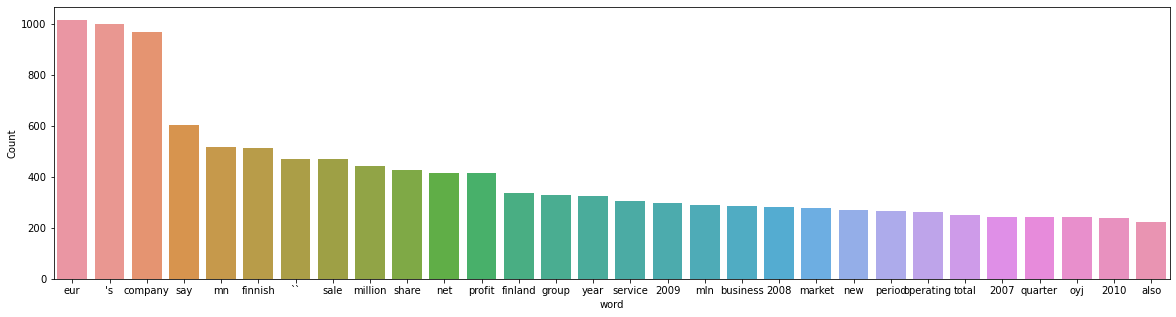

In [85]:
freq_words(financial_kaggle['title/clean'])

In [86]:
dictionary = corpora.Dictionary(financial_kaggle['title/no_stopwords'])
dictionary

In [87]:
doc_term_matrix = [dictionary.doc2bow(rev) for rev in financial_kaggle['title/no_stopwords']]

In [88]:
doc_term_matrix[0]

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [89]:
LDA = gensim.models.ldamodel.LdaModel
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=7, random_state=100,
                chunksize=1000, passes=50)

In [90]:
lda_model.print_topics()

[(0,
  '0.024*"company" + 0.023*"\'s" + 0.016*"market" + 0.014*"finland" + 0.012*"business" + 0.009*"say" + 0.008*"``" + 0.008*"service" + 0.007*"product" + 0.006*"customer"'),
 (1,
  '0.072*"eur" + 0.039*"mn" + 0.025*"profit" + 0.020*"sale" + 0.019*"operating" + 0.018*"\'s" + 0.018*"net" + 0.016*"period" + 0.016*"total" + 0.013*"million"'),
 (2,
  '0.014*"company" + 0.012*"bank" + 0.008*"plant" + 0.008*"finnish" + 0.007*"facility" + 0.007*"oil" + 0.007*"contract" + 0.007*"order" + 0.006*"group" + 0.006*"global"'),
 (3,
  '0.037*"mln" + 0.027*"euro" + 0.022*"million" + 0.017*"finnish" + 0.014*"oyj" + 0.014*"percent" + 0.011*"say" + 0.011*"net" + 0.010*"2007" + 0.009*"2006"'),
 (4,
  '0.014*"\'s" + 0.009*"paper" + 0.009*"company" + 0.009*"plant" + 0.007*"well" + 0.007*"production" + 0.007*"area" + 0.007*"say" + 0.006*"finnish" + 0.006*"negotiation"'),
 (5,
  '0.019*"year" + 0.019*"say" + 0.018*"company" + 0.016*"2010" + 0.014*"share" + 0.012*"2009" + 0.012*"finnish" + 0.010*"oyj" + 0.00

In [106]:
lda_model.get_document_topics(doc_term_matrix)[0]

[(0, 0.62503785),
 (1, 0.013015118),
 (2, 0.30989853),
 (3, 0.01300872),
 (4, 0.013025089),
 (5, 0.0130145475),
 (6, 0.013000122)]

In [105]:
doc_topic = lda_model.get_document_topics(doc_term_matrix)
topics = []
for i in range(len(doc_topic)):
    topics.append(max(doc_topic[i], key=lambda item:item[1])[0])
financial_kaggle['Topic'] = topics
financial_kaggle

,Sentiment,Article,title/no_stopwords,Topic
0,neutral,"According to Gran , the company has no plans t...","[According, to, Gran, ,, the, company, have, n...",0
1,neutral,Technopolis plans to develop in stages an area...,"[Technopolis, plan, to, develop, in, stage, an...",4
2,negative,The international electronic industry company ...,"[The, international, electronic, industry, com...",2
3,positive,With the new production plant the company woul...,"[With, the, new, production, plant, the, compa...",4
4,positive,According to the company 's updated strategy f...,"[According, to, the, company, 's, updated, str...",1
...,...,...,...,...
4841,negative,LONDON MarketWatch -- Share prices ended lower...,"[LONDON, MarketWatch, --, Share, price, end, l...",6
4842,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...,"[Rinkuskiai, 's, beer, sale, fell, by, 6.5, pe...",3
4843,negative,Operating profit fell to EUR 35.4 mn from EUR ...,"[Operating, profit, fell, to, EUR, 35.4, mn, f...",1
4844,negative,Net sales of the Paper segment decreased to EU...,"[Net, sale, of, the, Paper, segment, decrease,...",1


In [44]:
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
pd.DataFrame({'a': [1,2]})

,a
0,1
1,2


In [ ]:
pyLDAvis.enable_notebook()
gensimvis.prepare(lda_model, doc_term_matrix, dictionary)

In [73]:
doc_term_matrix[0]

[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]

In [ ]:
# TF-IDF
# BERT - already trained
# LDA - different neural networks for different topics ~ 10 topics depending on the data
# train on text; predict percent change
# predict one month from article
# 10% threshold to buy/sell